# Adaline with Stochastic Gradient Descent
The following code implements a simple object oriented Adaline classifier API trained using Stochastic Gradient Descent. SGD is useful to approximate full batch gradient descent and accelerate convergence toword the global minimum of the loss function. It can help avoid local minima due to its noisy approximation of the full batch gradient and it can also be used to perform online learning.

In [1]:
import numpy as np

class AdalineSGD:
    """A simple class implementation of the ADAptive LIner Neuron classifier using 
    SGD for training.
    
    Parameters
    -----------
    eta: float
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs (number of iterations over the training 
        dataset)
    random_state: int
        Seed for the random initialization of the weights and bias.
    tol: float
        Loss value threshold below which the training stops, even if less than
        n_iter epochs were performed.
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, tol=0.01):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self._wbinitialized = False
        self.random_state = random_state
        self.tol = tol
    
    def fit(self, X, y):
        """Trains the Adaline classifier to fit the training data using SGD

        Parameters
        -----------
        X: [array-like], shape = [n_samples, n_features]
            Training vectors. n_features is the number of predictors
            per sample, while n_sample is the number of samples in 
            the training dataset
        y: array-like, shape = [n_samples]
            Vector with the corresponding class for each of the
            training samples in the training dataset

        Returns
        --------
        self:  object
        """
        self._initwb(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses= []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
            if avg_loss < self.tol:
                print(f'End of training, converged after {i + 1} iterations.')
                break
        else:
            print(f'End of training, max n of iterations ({self.n_iter}) reached.')
        return self
    
    def predict(self, X):
        """Calculate the output of the Adaline classifier and return class prediction"""
        return np.where(self._activation(self._netinput(X)) >= 0.5, 1, 0)
  
    def partial_fit(self, X, y):
        """Partial fit function to perform online learning"""
        if not self._wbinitialized:
            self._initwb(X.shape[1])
        
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle the training data to avoid bias"""
        p = self.rgen_.permutation(len(y))
        return X[p], y[p]

    def _update_weights(self, xi, target):
        """Update weights and bias of the Adaline classifier"""
        output = self._activation(self._netinput(xi))
        error = (target - output)
        self.w_ += self.eta * xi * (error)
        self.b_ += self.eta * error
        loss = error**2
        return loss

    def _initwb(self, n_features):
        """Initialize weights and bias of the Adaline classifier"""
        self.rgen_ = np.random.RandomState(self.random_state)
        self.w_ = self.rgen_.normal(loc=0.0, scale=0.01, size=n_features)
        self.b_ = np.float_(0.)
        self._wbinitialized = True

    def _netinput(self, X):
        """Calculate the weighted sum input to the neuron"""
        return np.dot(X, self.w_) + self.b_
    
    def _activation(self, X):
        """Adaline activation function"""
        return X

# Iris Dataset
We will use the Iris Dataset to test this simple Adaline implementation with SGD.

In [2]:
import pandas as pd
df = pd.read_csv("iris.data.csv", header=None, encoding='utf-8')
df.tail()

# Select only Setosa and Versicolor targets
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# Extract sepal and petal length
X = df.iloc[0:100, [0, 2]].values

# Make a standardized copy of the original dataset
X_std = X.copy()
X_std[:,0] = (X_std[:,0] - X_std[:,0].mean()) / X_std[:,0].std()
X_std[:,1] = (X_std[:,1] - X_std[:,1].mean()) / X_std[:,1].std()

End of training, max n of iterations (15) reached.


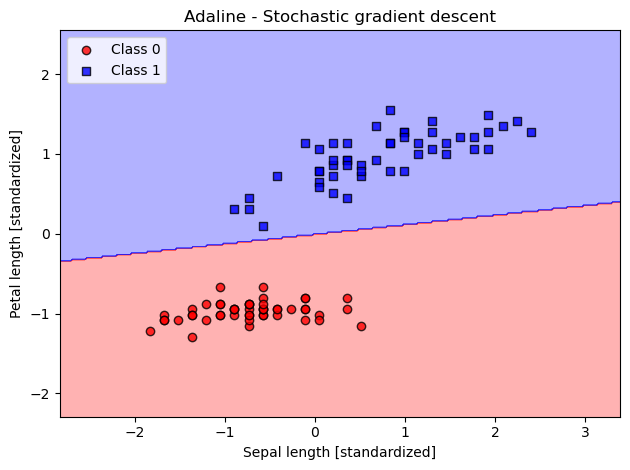

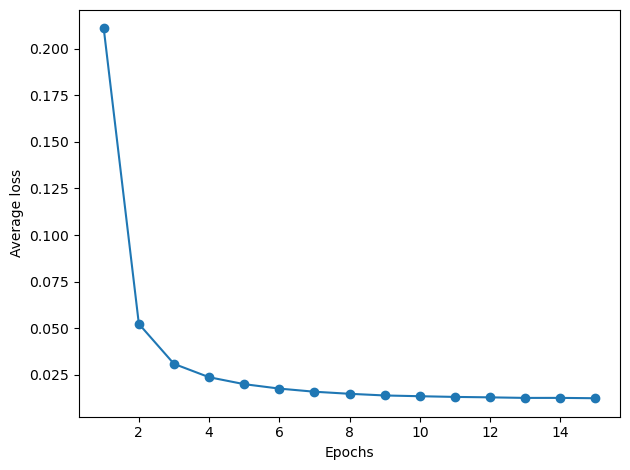

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Function used to plot the decision boundary
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class example
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

# Train the classifier, plot the decision boundary and the average loss value for each epoch
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.tight_layout()
plt.show()